In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to read LLM data
def read_llm_data(root_folder):
    # Get all subfolders
    subfolders = sorted([f.path for f in os.scandir(root_folder) if f.is_dir()])[:1000]
    
    # Initialize the pool
    pool_losses = []
    
    # Helper function to safely read loss values from files
    def safe_read_loss(file_path):
        try:
            with open(file_path, 'r') as file:
                loss_value = float(file.read().strip())
            return loss_value
        except (FileNotFoundError, ValueError):
            return None  # Return None if the file is missing or the content is invalid
    
    # Read the first 10 subfolders (initial Pool)
    for i in range(10):
        file_path = os.path.join(subfolders[i], 'best_loss.txt')
        loss_value = safe_read_loss(file_path)
        if loss_value is not None:
            pool_losses.append(loss_value)
    
    # Initialize lists to record data after each iteration
    average_losses_per_iteration = [np.mean(pool_losses)] if pool_losses else [None]
    best_losses_per_iteration = [min(pool_losses)] if pool_losses else [None]
    worst_losses_per_iteration = [max(pool_losses)] if pool_losses else [None]
    new_structure_avg_losses = []  # To record the average loss of the three new structures for each iteration
    new_structure_best_losses = []  # To record the best loss among the three new structures for each iteration
    new_structure_worst_losses = []  # To record the worst loss among the three new structures for each iteration
    
    # Iterate over the folders generated in each iteration
    for i in range(10, len(subfolders), 3):  # Process 3 new model folders each time
        new_losses = []
        
        for j in range(3):
            folder_index = i + j
            if folder_index < len(subfolders):
                file_path = os.path.join(subfolders[folder_index], 'best_loss.txt')
                loss_value = safe_read_loss(file_path)
                if loss_value is not None:
                    new_losses.append(loss_value)
        
        # Calculate statistics for the three new structures and record them
        if new_losses:
            new_avg_loss = np.mean(new_losses)
            new_best_loss = min(new_losses)
            new_worst_loss = max(new_losses)
            
            new_structure_avg_losses.append(new_avg_loss)
            new_structure_best_losses.append(new_best_loss)
            new_structure_worst_losses.append(new_worst_loss)
            
            # Combine the new losses with the current pool losses
            combined_losses = pool_losses + new_losses
            
            # Select the best 10 structures to remain in the pool
            pool_losses = sorted(combined_losses)[:10]
            
            # Record the current statistics
            average_losses_per_iteration.append(np.mean(pool_losses))
            best_losses_per_iteration.append(min(pool_losses))
            worst_losses_per_iteration.append(max(pool_losses))
            
    
    # Return the recorded data
    return {
        'average_losses_per_iteration': average_losses_per_iteration,
        'best_losses_per_iteration': best_losses_per_iteration,
        'worst_losses_per_iteration': worst_losses_per_iteration,
        'new_structure_best_losses': new_structure_best_losses,
        'new_structure_worst_losses': new_structure_worst_losses
    }

# Function to read EA data
def read_ea_data(csv_file_path):
    # Load the CSV file
    df = pd.read_csv(csv_file_path)
    
    # Group by generation to calculate best, worst, and average losses for parents
    best_losses_per_iteration_EA = []
    worst_losses_per_iteration_EA = []
    average_losses_per_iteration_EA = []
    
    # For new structures (last 3 of each generation)
    best_losses_new_structures = []
    worst_losses_new_structures = []
    average_losses_new_structures = []
    
    # Assuming each generation has 13 rows: first 10 are parents, last 3 are new structures
    num_parents = 10
    num_new_structures = 3
    
    for generation, group in df.groupby('Generation'):
        # Parents' losses (first 10)
        parents_losses = group['Loss'].iloc[:num_parents]
        best_losses_per_iteration_EA.append(parents_losses.min())
        worst_losses_per_iteration_EA.append(parents_losses.max())
        average_losses_per_iteration_EA.append(parents_losses.mean())
        
        # New structures' losses (last 3)
        new_structures_losses = group['Loss'].iloc[-num_new_structures:]
        best_losses_new_structures.append(new_structures_losses.min())
        worst_losses_new_structures.append(new_structures_losses.max())
        average_losses_new_structures.append(new_structures_losses.mean())
    
    # Return the data
    return {
        'average_losses_per_iteration': average_losses_per_iteration_EA,
        'best_losses_per_iteration': best_losses_per_iteration_EA,
        'worst_losses_per_iteration': worst_losses_per_iteration_EA,
        'new_structure_best_losses': best_losses_new_structures,
        'new_structure_worst_losses': worst_losses_new_structures
    }

def read_random_data(file_path):
    # Load the CSV file
    df = pd.read_csv(file_path)
    
    # Initialize lists to record the loss metrics
    best_losses_per_iteration = []
    worst_losses_per_iteration = []
    average_losses_per_iteration = []
    
    new_structure_best_losses = []
    new_structure_worst_losses = []
    new_structure_avg_losses = []
    
    pool_losses = []  # To track the pool of top 10 models

    for generation, group in df.groupby('Generation'):
        # Get the newly generated models in the current generation
        new_losses = group['Loss'].tolist()
        
        # Add the new models' losses to the pool (existing top 10 + new models)
        combined_losses = pool_losses + new_losses
        
        # Sort combined losses and keep the top 10 models in the pool
        pool_losses = sorted(combined_losses)[:10]
        
        # Store pool statistics for the current generation
        best_losses_per_iteration.append(min(pool_losses))
        worst_losses_per_iteration.append(max(pool_losses))
        average_losses_per_iteration.append(np.mean(pool_losses))
        
        # Store statistics for the new models in this generation
        new_structure_best_losses.append(min(new_losses))
        new_structure_worst_losses.append(max(new_losses))
        new_structure_avg_losses.append(np.mean(new_losses))
    
    # Return the recorded data in the required structure
    return {
        'average_losses_per_iteration': average_losses_per_iteration,
        'best_losses_per_iteration': best_losses_per_iteration,
        'worst_losses_per_iteration': worst_losses_per_iteration,
        'new_structure_best_losses': new_structure_best_losses,
        'new_structure_worst_losses': new_structure_worst_losses
    }

# Function to read BO data
def read_bo_data(folder_path):
    generation_csv_path = os.path.join(folder_path, 'generation_log.csv')
    pool_loss_csv_path = os.path.join(folder_path, 'model_pool_loss_history.csv')
    
    # Load pool loss file
    pool_df = pd.read_csv(pool_loss_csv_path)
    initial_pool_losses = pool_df['Best_Total_Loss'].tolist()

    # Initialize pool data
    pool_losses = initial_pool_losses[:10]
    
    # Read the generation data
    generation_df = pd.read_csv(generation_csv_path)
    
    # Initialize lists to record data after each iteration
    average_losses_per_iteration = [np.mean(pool_losses)]
    best_losses_per_iteration = [min(pool_losses)]
    worst_losses_per_iteration = [max(pool_losses)]
    new_structure_avg_losses = []  # To record the average loss of the new structures for each iteration
    new_structure_best_losses = []  # To record the best loss among the new structures for each iteration
    new_structure_worst_losses = []  # To record the worst loss among the new structures for each iteration

    # Iterate over the dataframe with a step of 3 to group new structures into generations
    for i in range(0, len(generation_df), 3):
        new_losses = []
        
        # Get the three new structures for this generation
        for j in range(3):
            if i + j < len(generation_df):
                new_loss = generation_df.iloc[i + j]['Loss']
                new_losses.append(new_loss)

        # Calculate statistics for the three new structures and record them
        if new_losses:
            new_avg_loss = np.mean(new_losses)
            new_best_loss = min(new_losses)
            new_worst_loss = max(new_losses)
            
            new_structure_avg_losses.append(new_avg_loss)
            new_structure_best_losses.append(new_best_loss)
            new_structure_worst_losses.append(new_worst_loss)
            
            # Update the pool with the new losses and keep the top 10
            combined_losses = pool_losses + new_losses
            pool_losses = sorted(combined_losses)[:10]

            # Record the statistics for the current pool
            average_losses_per_iteration.append(np.mean(pool_losses))
            best_losses_per_iteration.append(min(pool_losses))
            worst_losses_per_iteration.append(max(pool_losses))

    # Return the recorded data
    return {
        'average_losses_per_iteration': average_losses_per_iteration,
        'best_losses_per_iteration': best_losses_per_iteration,
        'worst_losses_per_iteration': worst_losses_per_iteration,
        'new_structure_best_losses': new_structure_best_losses,
        'new_structure_worst_losses': new_structure_worst_losses
    }


# Update plot_single_data function to handle BO data
def plot_single_data(data, method_name):
    # Check and filter out invalid values (None or NaN) from the data
    best_losses = [loss for loss in data['best_losses_per_iteration'] if loss is not None and np.isfinite(loss)]
    worst_losses = [loss for loss in data['worst_losses_per_iteration'] if loss is not None and np.isfinite(loss)]
    average_losses = [loss for loss in data['average_losses_per_iteration'] if loss is not None and np.isfinite(loss)]
    
    if len(best_losses) == 0 or len(worst_losses) == 0 or len(average_losses) == 0:
        print(f"Error: No valid data to plot for {method_name}")
        return

    # Plot the data
    plt.figure(figsize=(10, 8))

    # First chart: Best, Worst, and Average Loss in the Pool
    plt.subplot(2, 1, 1)
    x_range = range(len(best_losses))
    plt.fill_between(x_range,
                     best_losses,
                     worst_losses,
                     color='lightgreen', alpha=0.3, label='Pool Loss Range')
    plt.plot(x_range, average_losses, linestyle='-', linewidth=2, color='green', label='Pool Average Loss')
    
    plt.title(f'Pool Loss Trends Over Iterations ({method_name})', fontsize=14, fontweight='bold')
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.yscale('log')
    plt.ylim(0, max(worst_losses) * 1.1)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(fontsize=8, loc='lower left', frameon=False)  # Legend in bottom-left

    # Second chart: Best, Worst, and Average Loss of New Structures
    new_structure_best_losses = [loss for loss in data['new_structure_best_losses'] if loss is not None and np.isfinite(loss)]
    new_structure_worst_losses = [loss for loss in data['new_structure_worst_losses'] if loss is not None and np.isfinite(loss)]
    
    if len(new_structure_best_losses) == 0 or len(new_structure_worst_losses) == 0:
        print(f"Warning: No valid new structure loss data for {method_name}")
        return

    plt.subplot(2, 1, 2)
    new_x_range = range(1, len(new_structure_best_losses) + 1)
    plt.fill_between(new_x_range,
                     new_structure_best_losses,
                     new_structure_worst_losses,
                     color='lightblue', alpha=0.3, label='New Structures Loss Range')
    plt.plot(new_x_range, new_structure_best_losses, linestyle='-', linewidth=2, color='blue', label='New Structures Best Loss')
    
    plt.title('New Structures Loss Trends Over Iterations', fontsize=12, fontweight='bold')
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.yscale('log')
    plt.ylim(0, max(new_structure_worst_losses) * 1.1)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(fontsize=8, loc='lower left', frameon=False)  # Legend in bottom-left
    
    plt.tight_layout()
    plt.show()

# Update plot_combined_data function to include BO data
def plot_combined_data(data_dict):
    num_points = 100  # Set the number of points to display for each method

    # Create figure
    plt.figure(figsize=(6, 8))

    # Define color schemes for different methods
    color_schemes = {
        'LLM': {'range_color': '#FFB6C1', 'avg_color': '#FF69B4'},
        'EA': {'range_color': '#87CEFA', 'avg_color': '#4682B4'},
        'Random': {'range_color': '#90EE90', 'avg_color': '#32CD32'},
        'BO': {'range_color': '#FFD700', 'avg_color': '#FFA500'}
    }

    # First chart: Best, Worst, and Average Loss in the Pool
    plt.subplot(2, 1, 1)
    for method_name, data in data_dict.items():
        # Filter out invalid values (None, NaN, etc.) before plotting
        best_losses = [loss for loss in data['best_losses_per_iteration'][:num_points] if loss is not None and np.isfinite(loss)]
        worst_losses = [loss for loss in data['worst_losses_per_iteration'][:num_points] if loss is not None and np.isfinite(loss)]
        average_losses = [loss for loss in data['average_losses_per_iteration'][:num_points] if loss is not None and np.isfinite(loss)]
        
        if len(best_losses) == 0 or len(worst_losses) == 0 or len(average_losses) == 0:
            print(f"Warning: No valid data to plot for {method_name}")
            continue
        
        colors = color_schemes.get(method_name, {'range_color': 'grey', 'avg_color': 'black'})
        
        # Plot the range between best and worst losses
        plt.fill_between(range(len(best_losses)),
                         best_losses,
                         worst_losses,
                         color=colors['range_color'], alpha=0.3, label=f'Pool Loss Range ({method_name})')
        
        # Plot the average losses
        plt.plot(range(len(average_losses)), average_losses,
                 linestyle='-', linewidth=2, color=colors['avg_color'], label=f'Pool Average Loss ({method_name})')
        
        # Highlight the minimum best loss with a small triangle of the same color as the line
        min_best_loss = min(best_losses)
        min_best_loss_idx = best_losses.index(min_best_loss)
        plt.plot(min_best_loss_idx, min_best_loss, marker='v', color=colors['avg_color'], markersize=5, label=f'Min Best Loss ({method_name})')

    plt.title('Pool Loss Trends Over Iterations', fontsize=12, fontweight='bold', color='#333333')
    plt.xlabel('Iteration', fontsize=12, fontweight='bold', color='#555555')
    plt.ylabel('Loss', fontsize=12, fontweight='bold', color='#555555')
    plt.yscale('log')
    plt.ylim(0, 5)
    plt.grid(True, which='both', linestyle='--', linewidth=0.7, color='#DDDDDD')
    plt.legend(fontsize=8, loc='lower left', frameon=False)  # Legend in bottom-left

    # Second chart: Best, Worst, and Average Loss of New Structures
    plt.subplot(2, 1, 2)
    for method_name, data in data_dict.items():
        # Filter out invalid values (None, NaN, etc.) before plotting
        best_new_losses = [loss for loss in data['new_structure_best_losses'][:num_points] if loss is not None and np.isfinite(loss)]
        worst_new_losses = [loss for loss in data['new_structure_worst_losses'][:num_points] if loss is not None and np.isfinite(loss)]
        
        if len(best_new_losses) == 0 or len(worst_new_losses) == 0:
            print(f"Warning: No valid new structure data to plot for {method_name}")
            continue
        
        colors = color_schemes.get(method_name, {'range_color': 'grey', 'avg_color': 'black'})
        
        # Plot the range between best and worst losses
        plt.fill_between(range(len(best_new_losses)),
                         best_new_losses,
                         worst_new_losses,
                         color=colors['range_color'], alpha=0.3, label=f'New Structures Loss Range ({method_name})')
        
        # Plot the best new losses
        plt.plot(range(len(best_new_losses)), best_new_losses,
                 linestyle='-', linewidth=2, color=colors['avg_color'], label=f'New Structures Best Loss ({method_name})')
        
        # Highlight the minimum new structure best loss with a small triangle of the same color as the line
        min_new_best_loss = min(best_new_losses)
        min_new_best_loss_idx = best_new_losses.index(min_new_best_loss)
        plt.plot(min_new_best_loss_idx, min_new_best_loss, marker='v', color=colors['avg_color'], markersize=5, label=f'Min Best New Loss ({method_name})')

    plt.title('Loss Trends of New Structures Across Generations', fontsize=12, fontweight='bold', color='#333333')
    plt.xlabel('Generation', fontsize=12, fontweight='bold', color='#555555')
    plt.ylabel('Loss', fontsize=12, fontweight='bold', color='#555555')
    plt.yscale('log')
    plt.ylim(0, 5)
    plt.grid(True, which='both', linestyle='--', linewidth=0.7, color='#DDDDDD')
    plt.legend(fontsize=8, loc='lower left', frameon=False)  # Legend in bottom-left

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# Main function to generate plots
def generate_plots(plot_names, file_paths):
    data_dict = {}

    for method_name in plot_names:
        if method_name == 'LLM':
            root_folder = file_paths.get(method_name)
            if root_folder:
                data = read_llm_data(root_folder)
                data_dict[method_name] = data
            else:
                print(f"Error: LLM data file path not provided for {method_name}.")
        elif method_name == 'EA':
            csv_file_path = file_paths.get(method_name)
            if csv_file_path:
                data = read_ea_data(csv_file_path)
                data_dict[method_name] = data
            else:
                print(f"Error: EA data file path not provided for {method_name}.")
        elif method_name == 'Random':
            random_file_path = file_paths.get(method_name)
            if random_file_path:
                data = read_random_data(random_file_path)
                data_dict[method_name] = data
            else:
                print(f"Error: Random data file path not provided for {method_name}.")
        elif method_name == 'BO':
            folder_path = file_paths.get(method_name)
            if folder_path:
                data = read_bo_data(folder_path)
                data_dict[method_name] = data
            else:
                print(f"Error: BO data folder path not provided for {method_name}.")
        else:
            print(f"Error: Unknown method name '{method_name}'.")

    if len(data_dict) == 1:
        # Plot data for a single method
        method_name = list(data_dict.keys())[0]
        data = data_dict[method_name]
        plot_single_data(data, method_name)
    elif len(data_dict) > 1:
        # Plot combined data
        plot_combined_data(data_dict)
    else:
        print("Error: No valid data to plot.")

# Main function to generate plots with transparency and custom labels for multiple LLMs, EAs, BOs, etc.
def generate_plots_with_alpha_and_labels(plot_groups, file_paths, alpha_dict=None, label_dict=None):
    data_dict = {}

    # Set default alpha_dict and label_dict if not provided
    if alpha_dict is None:
        alpha_dict = {}
    if label_dict is None:
        label_dict = {}

    for method_type, method_list in plot_groups.items():
        for method_name in method_list:
            method_key = f"{method_type}_{method_name}"
            if method_type == 'LLM':
                root_folder = file_paths.get(method_key)
                if root_folder:
                    data = read_llm_data(root_folder)
                    data_dict[method_key] = data
                else:
                    print(f"Error: LLM data file path not provided for {method_key}.")
            elif method_type == 'EA':
                csv_file_path = file_paths.get(method_key)
                if csv_file_path:
                    data = read_ea_data(csv_file_path)
                    data_dict[method_key] = data
                else:
                    print(f"Error: EA data file path not provided for {method_key}.")
            elif method_type == 'Random':
                random_file_path = file_paths.get(method_key)
                if random_file_path:
                    data = read_random_data(random_file_path)
                    data_dict[method_key] = data
                else:
                    print(f"Error: Random data file path not provided for {method_key}.")
            elif method_type == 'BO':
                folder_path = file_paths.get(method_key)
                if folder_path:
                    data = read_bo_data(folder_path)
                    data_dict[method_key] = data
                else:
                    print(f"Error: BO data folder path not provided for {method_key}.")
            else:
                print(f"Error: Unknown method type '{method_type}'.")

    if data_dict:
        # Plot combined data with alpha and labels
        plot_combined_data_with_alpha(data_dict, alpha_dict, label_dict)
    else:
        print("Error: No valid data to plot.")

        
# Update plot_combined_data_with_alpha function to include BO data
def plot_combined_data_with_alpha(data_dict, alpha_dict, label_dict):
    num_points = 300  # Set the number of points to display for each method

    plt.figure(figsize=(6, 8))

    # Define color schemes for different methods with added alpha
    color_schemes = {
        'LLM': {'range_color': '#FFB6C1', 'avg_color': '#FF69B4'},
        'EA': {'range_color': '#87CEFA', 'avg_color': '#4682B4'},
        'Random': {'range_color': '#90EE90', 'avg_color': '#32CD32'},
        'BO': {'range_color': '#FFD700', 'avg_color': '#FFA500'}
    }

    # Plot Best, Worst, and Average Loss in the Pool
    plt.subplot(2, 1, 1)
    for method_key, data in data_dict.items():
        best_losses = [loss for loss in data['best_losses_per_iteration'][:num_points] if loss is not None and np.isfinite(loss)]
        worst_losses = [loss for loss in data['worst_losses_per_iteration'][:num_points] if loss is not None and np.isfinite(loss)]
        average_losses = [loss for loss in data['average_losses_per_iteration'][:num_points] if loss is not None and np.isfinite(loss)]

        if len(best_losses) == 0 or len(worst_losses) == 0 or len(average_losses) == 0:
            print(f"Warning: No valid data to plot for {method_key}")
            continue

        method_type, method_name = method_key.split("_", 1)  # Split the method type (LLM, EA, etc.) and its unique name
        colors = color_schemes.get(method_type, {'range_color': 'grey', 'avg_color': 'black'})
        
        # Use transparency (alpha) and check for label
        alpha_value = alpha_dict.get(method_key, 0.3)  # Default to 0.3 if not provided
        label = label_dict.get(method_key)  # Only use label if provided

        # Plot average loss
        min_best_loss = min(best_losses)
        min_best_loss_idx = best_losses.index(min_best_loss)

        if label:
            plt.plot(range(len(best_losses)), best_losses,
                     linestyle='-', linewidth=2, color=colors['avg_color'], alpha=alpha_value, label=f'Pool Best Loss ({label})')
            plt.plot(min_best_loss_idx, min_best_loss, marker='v', color=colors['avg_color'], markersize=6, label=f'Min Best Loss ({label})')
        else:
            plt.plot(range(len(best_losses)), best_losses,
                     linestyle='-', linewidth=1.5, color=colors['avg_color'], alpha=alpha_value)
            plt.plot(min_best_loss_idx, min_best_loss, marker='v', color=colors['avg_color'], markersize=6)

    plt.title('Pool Loss Trends Over Iterations', fontsize=12, fontweight='bold')
    plt.xlabel('Iteration', fontsize=12, fontweight='bold')
    plt.ylabel('Loss', fontsize=12, fontweight='bold')
    plt.yscale('log')

    # Only 
    if any(label_dict.get(key) for key in data_dict.keys()):
        plt.legend(fontsize=8, loc='upper right', frameon=False)

    plt.tight_layout()
    plt.show()

def read_and_plot_average(folder_paths, stats='mean'):
    data_dict = {
        'LLM': [],
        'EA': [],
        'Random': [],
        'BO': []
    }
    
    # Traverse and read data
    for method, folder_path in folder_paths.items():
        if method == 'LLM':
            subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]
            for subfolder in subfolders:
                data = read_llm_data(subfolder)
                data_dict['LLM'].append(data)
        elif method == 'EA':
            subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]
            for subfolder in subfolders:
                gen_log_path = os.path.join(subfolder, 'generation_log.csv')
                if os.path.exists(gen_log_path):
                    data = read_ea_data(gen_log_path)
                    data_dict['EA'].append(data)
        elif method == 'Random':
            subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]
            for subfolder in subfolders:
                gen_log_path = os.path.join(subfolder, 'generation_log.csv')
                if os.path.exists(gen_log_path):
                    data = read_random_data(gen_log_path)
                    data_dict['Random'].append(data)
        elif method == 'BO':
            subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]
            for subfolder in subfolders:
                data = read_bo_data(subfolder)
                data_dict['BO'].append(data)

    # Helper function to select statistic based on parameter
    def calculate_statistic(values, stat):
        if stat == 'mean':
            return np.mean(values)
        elif stat == 'median':
            return np.median(values)
        elif stat == 'min':
            return np.min(values)
        elif stat == 'max':
            return np.max(values)
        elif stat == 'std':
            return np.std(values)
        else:
            raise ValueError(f"Unsupported stat: {stat}")

    # Calculate the chosen statistic for each method
    avg_data_dict = {}
    for method, data_list in data_dict.items():
        if not data_list:
            continue
        avg_data = {
            'average_losses_per_iteration': [],
            'best_losses_per_iteration': [],
            'worst_losses_per_iteration': [],
            'new_structure_best_losses': [],
            'new_structure_worst_losses': []
        }
        num_data = len(data_list)

        # Iterate over each data point and calculate the selected statistic
        for key in avg_data.keys():
            max_len = max(len(data[key]) for data in data_list)
            avg_values = [calculate_statistic([data[key][i] for data in data_list if i < len(data[key])], stats) for i in range(max_len)]
            avg_data[key] = avg_values

        avg_data_dict[method] = avg_data

        # Print the last iteration's pool statistic for each run
        print(f"\n=== {method} Pool {stats.title()} Losses After Last Iteration (for each run) ===")
        for data in data_list:
            if data['average_losses_per_iteration']:
                last_loss = calculate_statistic(data['average_losses_per_iteration'], stats)
                print(f"Last iteration {stats} pool loss: {last_loss:.6f}")

    # Calculate variance across different runs for each method and print chosen statistic per folder
    print(f"\n{stats.title()} across different runs:")
    for method, data_list in data_dict.items():
        if not data_list:
            continue

        # Calculate statistic losses per folder/run
        losses_per_run = []
        for data in data_list:
            loss = calculate_statistic(data['average_losses_per_iteration'], stats)
            losses_per_run.append(loss)
            print(f"{stats.title()} loss for {method} in run: {loss:.4f}")

        # Calculate variance across runs
        variance = np.var(losses_per_run)
        print(f"Variance in {stats} losses for {method}: {variance:.4f}")

    # Plot the averaged data
    plot_combined_data(avg_data_dict)

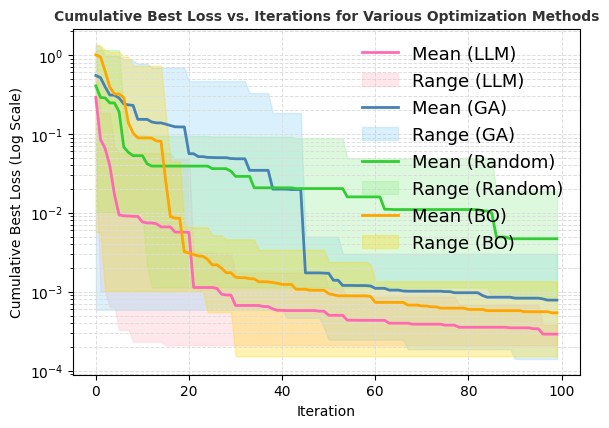

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_combined_data_new(avg_data_dict):
    num_points = 100  # Number of points to display for each method

    # Create a figure with a specified size
    plt.figure(figsize=(6, 8))

    # Define color schemes for different methods
    color_schemes = {
        'LLM': {'range_color': '#FFB6C1', 'avg_color': '#FF69B4'},
        'EA': {'range_color': '#87CEFA', 'avg_color': '#4682B4'},
        'Random': {'range_color': '#90EE90', 'avg_color': '#32CD32'},
        'BO': {'range_color': '#FFD700', 'avg_color': '#FFA500'}
    }
    
    # Map internal names to display names
    display_names = {
        'LLM': 'LLM',
        'EA': 'GA',
        'Random': 'Random',
        'BO': 'BO'
    }

    # -------------------------------
    # First Subplot: Pool Loss Trends
    # -------------------------------
    plt.subplot(2, 1, 1)
    for method_name, data in avg_data_dict.items():
        # Truncate data to num_points
        iterations = range(len(data['average_best_losses_per_iteration'][:num_points]))
        avg_losses = data['average_best_losses_per_iteration'][:num_points]
        min_losses = data.get('min_best_losses_per_iteration', [])[:num_points]
        max_losses = data.get('max_best_losses_per_iteration', [])[:num_points]

        # Get color scheme for the current method
        colors = color_schemes.get(method_name, {'range_color': 'grey', 'avg_color': 'black'})
        display_name = display_names.get(method_name, method_name)

        # Plot the average loss
        plt.plot(
            iterations,
            avg_losses,
            linestyle='-',
            linewidth=2,
            color=colors['avg_color'],
            label=f'Mean ({display_name})'
        )

        # Plot the shaded area between min and max
        plt.fill_between(
            iterations,
            min_losses,
            max_losses,
            color=colors['range_color'],
            alpha=0.3,
            label=f'Range ({display_name})'
        )

    # Set titles and labels for the first subplot
    plt.title(
        'Cumulative Best Loss vs. Iterations for Various Optimization Methods',
        fontsize=10,
        fontweight='bold',
        color='#333333'
    )
    plt.xlabel(
        'Iteration',
        fontsize=10,
        # fontweight='bold',
        # color='#555555'
    )
    plt.ylabel(
        'Cumulative Best Loss (Log Scale)',
        fontsize=10,
        # fontweight='bold',
        # color='#555555'
    )
    plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.grid(True, which='both', linestyle='--', linewidth=0.7, color='#DDDDDD')  # Add grid
    plt.legend(fontsize=13, loc='upper right', frameon=False)  # Adjusted legend location

    plt.tight_layout()  # 调整布局，避免标签遮挡
    plt.savefig('evaluation_outer.png', dpi=300)  # 保存，dpi设置为300以保证高清晰度
    plt.show()



def read_and_plot_average_new(folder_paths, stats='mean'):
    data_dict = {
        'LLM': [],
        'EA': [],
        'Random': [],
        'BO': []
    }

    # Traverse and read data
    for method, folder_path in folder_paths.items():
        if method not in data_dict:
            continue  # Skip unknown methods
        subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]
        for subfolder in subfolders:
            if method == 'LLM':
                data = read_llm_data(subfolder)
            elif method == 'EA':
                gen_log_path = os.path.join(subfolder, 'generation_log.csv')
                if os.path.exists(gen_log_path):
                    data = read_ea_data(gen_log_path)
                else:
                    continue
            elif method == 'Random':
                gen_log_path = os.path.join(subfolder, 'generation_log.csv')
                if os.path.exists(gen_log_path):
                    data = read_random_data(gen_log_path)
                else:
                    continue
            elif method == 'BO':
                data = read_bo_data(subfolder)
            else:
                continue  # Unknown method
            data_dict[method].append(data)

    # Helper function to select statistic based on parameter
    def calculate_statistic(values, stat):
        if stat == 'mean':
            return np.mean(values)
        elif stat == 'median':
            return np.median(values)
        elif stat == 'min':
            return np.min(values)
        elif stat == 'max':
            return np.max(values)
        elif stat == 'std':
            return np.std(values)
        else:
            raise ValueError(f"Unsupported stat: {stat}")

    # Calculate statistics for each method
    avg_data_dict = {}
    for method, data_list in data_dict.items():
        if not data_list:
            continue
        avg_data = {
            'average_best_losses_per_iteration': [],
            'min_best_losses_per_iteration': [],
            'max_best_losses_per_iteration': []
        }
        num_data = len(data_list)

        # Determine the maximum length across all runs for this method
        max_len = max(len(data.get('best_losses_per_iteration', [])) for data in data_list)

        for i in range(max_len):
            # Gather all loss values at iteration i across runs
            losses_at_i = [
                data['best_losses_per_iteration'][i]
                for data in data_list
                if 'best_losses_per_iteration' in data and i < len(data['best_losses_per_iteration']) and
                   data['best_losses_per_iteration'][i] is not None and
                   np.isfinite(data['best_losses_per_iteration'][i])
            ]

            if not losses_at_i:
                # If no valid data at this iteration, append NaN or skip
                avg_data['average_best_losses_per_iteration'].append(np.nan)
                avg_data['min_best_losses_per_iteration'].append(np.nan)
                avg_data['max_best_losses_per_iteration'].append(np.nan)
                continue

            # Calculate statistics
            avg_loss = calculate_statistic(losses_at_i, 'mean')
            min_loss = calculate_statistic(losses_at_i, 'min')
            max_loss = calculate_statistic(losses_at_i, 'max')

            # Append to avg_data
            avg_data['average_best_losses_per_iteration'].append(avg_loss)
            avg_data['min_best_losses_per_iteration'].append(min_loss)
            avg_data['max_best_losses_per_iteration'].append(max_loss)

        avg_data_dict[method] = avg_data

    # Plot the averaged data with variability
    plot_combined_data_new(avg_data_dict)

# Example usage:
# Define the folder paths for each method
folder_paths = {
    'LLM': '../experiments/case1_p2o/Evolution_LLM',
    'EA': '../experiments/case1_p2o/Evolution_EA',
    'Random': '../experiments/case1_p2o/Evolution_Random',
    'BO': '../experiments/case1_p2o/Evolution_BO'

}

# Call the function to read data and plot
read_and_plot_average_new(folder_paths, stats='mean')


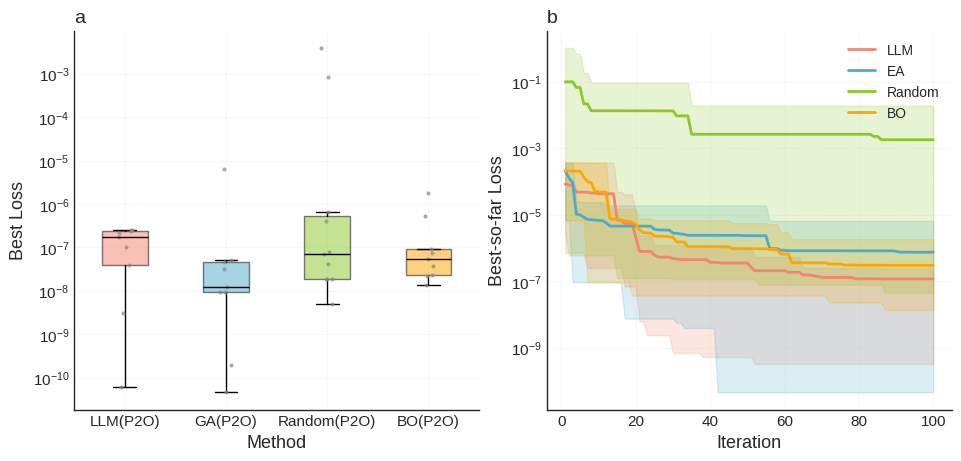

In [17]:


import matplotlib.pyplot as plt
import numpy as np
import scienceplots     

def plot_combined_minmax_and_boxplot(avg_data_dict, raw_data_dict, num_points=100):
    # —— 1. 论文级风格 & 字体 —— #
    plt.style.use('seaborn-v0_8-white')
    plt.rcParams.update({
        # 'font.family':      'serif',
        'font.size':        12,
        'axes.titlesize':   14,
        'axes.labelsize':   13,
        'legend.fontsize':  10,
        'xtick.labelsize':  11,
        'ytick.labelsize':  11,
        'axes.linewidth':   1.0,
        'lines.linewidth':  2.0,
        'grid.alpha':       0.3,
    })

    # —— 2. 统一配色 —— #
    # color_schemes = {
    #     'LLM':    {'avg_color':'#FF69B4', 'range_color':'#FFB6C1'},
    #     'EA':     {'avg_color':'#4682B4', 'range_color':'#87CEFA'},
    #     'Random': {'avg_color':'#32CD32', 'range_color':'#90EE90'},
    #     'BO':     {'avg_color':'#FFA500', 'range_color':'#FFD700'},
    # }
    color_schemes = {
        'LLM':    {'avg_color':'#F4856D', 'range_color':'#FFB6C1'},
        'EA':     {'avg_color':'#4EABC8', 'range_color':'#87CEFA'},
        'Random': {'avg_color':'#8AC926', 'range_color':'#90EE90'},
        'BO':     {'avg_color':'#FFA500', 'range_color':'#FFD700'},
    }
    
    # Map internal names to display names
    display_names = {
        'LLM': 'LLM(P2O)',
        'EA': 'GA(P2O)',
        'Random': 'Random(P2O)',
        'BO': 'BO(P2O)'
    }

    methods = list(avg_data_dict.keys())
    fig, axes = plt.subplots(1, 2, figsize=(9.5, 4.5), constrained_layout=True)

    # —— a) Boxplot —— #
    ax = axes[0]
    box_data = [
        [run['best_losses_per_iteration'][-1]
         for run in raw_data_dict[m]
         if run.get('best_losses_per_iteration') and np.isfinite(run['best_losses_per_iteration'][-1])]
        for m in methods
    ]
    # Create display labels for boxplot
    box_labels = [display_names.get(m, m) for m in methods]
    bplot = ax.boxplot(box_data, labels=box_labels, patch_artist=True, showfliers=False)

    # 填色 & 边框
    for patch, m in zip(bplot['boxes'], methods):
        patch.set_facecolor(color_schemes[m]['avg_color'])
        patch.set_alpha(0.5)
        patch.set_edgecolor('black')
        patch.set_linewidth(1)
    for elem in ('whiskers','caps','medians'):
        for line in bplot[elem]:
            line.set_color('black')
            line.set_linewidth(1)

    # 灰点叠加
    for i, vals in enumerate(box_data):
        xs = np.random.normal(i+1, 0.04, size=len(vals))
        ax.plot(xs, vals, '.', color='#888888', alpha=0.6, markersize=4)

    ax.set_title('a', loc='left')
    ax.set_xlabel('Method')
    ax.set_ylabel('Best Loss')
    ax.set_yscale('log')
    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # —— b) Mean & Min–Max 收敛曲线 —— #
    ax = axes[1]
    for m in methods:
        avg = np.array(avg_data_dict[m]['average_best_losses_per_iteration'])[:num_points]
        mn  = np.array(avg_data_dict[m]['min_best_losses_per_iteration'])[:num_points]
        mx  = np.array(avg_data_dict[m]['max_best_losses_per_iteration'])[:num_points]
        x   = np.arange(1, len(avg)+1)
        c   = color_schemes[m]['avg_color']

        ax.plot(x, avg, label=m, color=c)
        ax.fill_between(x, mn, mx, color=c, alpha=0.2)

    ax.set_title('b', loc='left')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Best-so-far Loss')
    ax.set_yscale('log')
    ax.legend(loc='upper right', frameon=False)
    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.savefig("figure2_minmax_combined_paper_style_old.png", dpi=300)
    plt.show()




    
def read_and_plot_average_new(folder_paths, stats='mean'):
    data_dict = {
        'LLM': [],
        'EA': [],
        'Random': [],
        'BO': []
    }

    # Traverse and read data
    for method, folder_path in folder_paths.items():
        if method not in data_dict:
            continue  # Skip unknown methods
        subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]
        for subfolder in subfolders:
            if method == 'LLM':
                data = read_llm_data(subfolder)
            elif method == 'EA':
                gen_log_path = os.path.join(subfolder, 'generation_log.csv')
                if os.path.exists(gen_log_path):
                    data = read_ea_data(gen_log_path)
                else:
                    continue
            elif method == 'Random':
                gen_log_path = os.path.join(subfolder, 'generation_log.csv')
                if os.path.exists(gen_log_path):
                    data = read_random_data(gen_log_path)
                else:
                    continue
            elif method == 'BO':
                data = read_bo_data(subfolder)
            else:
                continue  # Unknown method
            data_dict[method].append(data)

    # Helper function to select statistic based on parameter
    def calculate_statistic(values, stat):
        if stat == 'mean':
            return np.mean(values)
        elif stat == 'median':
            return np.median(values)
        elif stat == 'min':
            return np.min(values)
        elif stat == 'max':
            return np.max(values)
        elif stat == 'std':
            return np.std(values)
        else:
            raise ValueError(f"Unsupported stat: {stat}")

    # Calculate statistics for each method
    avg_data_dict = {}
    for method, data_list in data_dict.items():
        if not data_list:
            continue
        avg_data = {
            'average_best_losses_per_iteration': [],
            'min_best_losses_per_iteration': [],
            'max_best_losses_per_iteration': []
        }
        num_data = len(data_list)

        # Determine the maximum length across all runs for this method
        max_len = max(len(data.get('best_losses_per_iteration', [])) for data in data_list)

        for i in range(max_len):
            # Gather all loss values at iteration i across runs
            losses_at_i = [
                data['best_losses_per_iteration'][i]
                for data in data_list
                if 'best_losses_per_iteration' in data and i < len(data['best_losses_per_iteration']) and
                   data['best_losses_per_iteration'][i] is not None and
                   np.isfinite(data['best_losses_per_iteration'][i])
            ]

            if not losses_at_i:
                # If no valid data at this iteration, append NaN or skip
                avg_data['average_best_losses_per_iteration'].append(np.nan)
                avg_data['min_best_losses_per_iteration'].append(np.nan)
                avg_data['max_best_losses_per_iteration'].append(np.nan)
                continue

            # Calculate statistics
            avg_loss = calculate_statistic(losses_at_i, 'mean')
            min_loss = calculate_statistic(losses_at_i, 'min')
            max_loss = calculate_statistic(losses_at_i, 'max')

            # Append to avg_data
            avg_data['average_best_losses_per_iteration'].append(avg_loss)
            avg_data['min_best_losses_per_iteration'].append(min_loss)
            avg_data['max_best_losses_per_iteration'].append(max_loss)

        avg_data_dict[method] = avg_data

    # Plot the averaged data with variability
    plot_combined_minmax_and_boxplot(avg_data_dict, data_dict)

# Example usage:
# Define the folder paths for each method
folder_paths = {
    'LLM': '../experiments/case1_p2o/Evolution_LLM',
    'EA': '../experiments/case1_p2o/Evolution_EA',
    'Random': '../experiments/case1_p2o/Evolution_Random',
    'BO': '../experiments/case1_p2o/Evolution_BO'
}

folder_paths = {
    'LLM': '../experiments/case1_p2o/Evolution_LLM_constant',
    'EA': '../experiments/case1_p2o/Evolution_EA_constant',
    'Random': '../experiments/case1_p2o/Evolution_Random_constant',
    'BO': '../experiments/case1_p2o/Evolution_BO_constant'
}



# Call the function to read data a
# nd plot
read_and_plot_average_new(folder_paths, stats='mean')

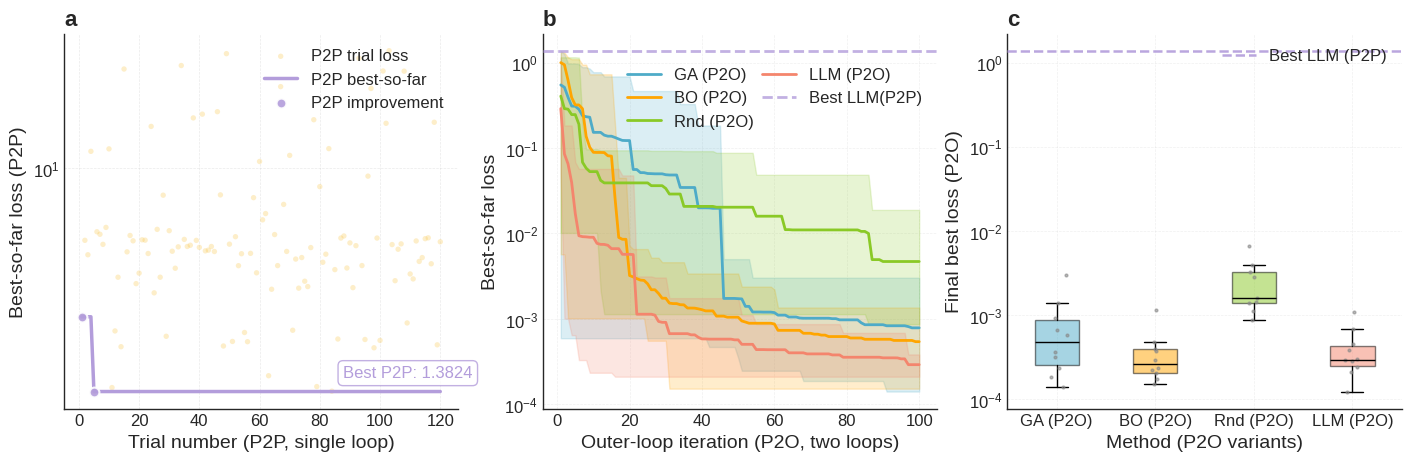


P2P (single-loop) Optimization Summary
Total trials: 120
Total improvements: 2
Initial loss: 2.680931
Final best loss (P2P): 1.382387
Loss reduction: 48.44%
Improvement rate: 1.67%



In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import scienceplots

def plot_combined_with_control(avg_data_dict, raw_data_dict, control_csv_path, num_points=100):
    """
    Creates a combined figure with three subplots:
    a) P2P (single loop) optimization performance
    b) P2O (two-loop) convergence curves with best P2P as reference
    c) Boxplot of P2O methods with best P2P as reference
    """
    
    # Read Control (P2P single-loop) simulation data
    df = pd.read_csv(control_csv_path)
    
    # Calculate best loss so far for P2P
    best_loss_so_far = []
    current_best = float('inf')
    
    for idx, row in df.iterrows():
        loss = row['Child_Loss']
        if loss < current_best:
            current_best = loss
        best_loss_so_far.append(current_best)
    
    trial_numbers = list(range(1, len(best_loss_so_far) + 1))
    all_losses = df['Child_Loss'].values
    
    # Mark improvement points in P2P
    improvement_indices = [0]
    for i in range(1, len(best_loss_so_far)):
        if best_loss_so_far[i] < best_loss_so_far[i-1]:
            improvement_indices.append(i)
    
    improvement_trials = [trial_numbers[i] for i in improvement_indices]
    improvement_losses = [best_loss_so_far[i] for i in improvement_indices]
    
    # Setup style
    plt.style.use('seaborn-v0_8-white')
    plt.rcParams.update({
        'font.size':        14,
        'axes.titlesize':   16,
        'axes.labelsize':   14,
        'legend.fontsize':  12,
        'xtick.labelsize':  12,
        'ytick.labelsize':  12,
        'axes.linewidth':   1.0,
        'lines.linewidth':  2.0,
        'grid.alpha':       0.3,
    })
    
    # Color schemes
    color_schemes = {
        'LLM':    {'avg_color':'#F4856D', 'range_color':'#FFB6C1'},
        'EA':     {'avg_color':'#4EABC8', 'range_color':'#87CEFA'},
        'Random': {'avg_color':'#8AC926', 'range_color':'#90EE90'},
        'BO':     {'avg_color':'#FFA500', 'range_color':'#FFD700'},
        'P2P':    {'avg_color':'#B39DDB', 'scatter_color':'#F9C74F'}
    }
    
    # Map internal names to display names (P2O variants)
    display_names = {
        'LLM':   'LLM (P2O)',
        'EA':    'GA (P2O)',
        'Random':'Rnd (P2O)',
        'BO':    'BO (P2O)'
    }
    
    # Define methods order for plot c: EA, BO, Random, LLM
    methods_order = ['EA', 'BO', 'Random', 'LLM']
    methods = [m for m in methods_order if m in avg_data_dict]
    
    # Create figure with 3 subplots (1 row, 3 columns)
    fig, axes = plt.subplots(1, 3, figsize=(14, 4.5), constrained_layout=True)
    
    # ============================================================
    # a) P2P (single-loop) Optimization Plot
    # ============================================================
    ax = axes[0]
    
    # Sample points for scatter to avoid over-plotting
    sample_interval = max(1, len(trial_numbers) // 100)
    sampled_indices = range(0, len(trial_numbers), sample_interval)
    sampled_trials = [trial_numbers[i] for i in sampled_indices]
    sampled_losses = [all_losses[i] for i in sampled_indices]
    
    ax.scatter(
        sampled_trials, sampled_losses,
        alpha=0.3, s=15,
        color=color_schemes['P2P']['scatter_color'],
        label='P2P trial loss',
        zorder=1, edgecolors='none'
    )
    
    ax.plot(
        trial_numbers, best_loss_so_far,
        linewidth=2.5,
        color=color_schemes['P2P']['avg_color'],
        label='P2P best-so-far',
        zorder=3
    )
    
    ax.scatter(
        improvement_trials, improvement_losses,
        s=50,
        color=color_schemes['P2P']['avg_color'],
        marker='o',
        label='P2P improvement',
        zorder=4,
        edgecolors='white', linewidths=1.5, alpha=0.9
    )
    
    # Add annotation for the best P2P value (inside the plot)
    p2p_best = best_loss_so_far[-1]
    ax.annotate(
        f'Best P2P: {p2p_best:.4f}', 
        xy=(trial_numbers[-1], p2p_best), 
        xytext=(-70, 10), textcoords='offset points',
        fontsize=12, color=color_schemes['P2P']['avg_color'],
        bbox=dict(
            boxstyle='round,pad=0.3',
            facecolor='white',
            edgecolor=color_schemes['P2P']['avg_color'],
            alpha=0.8
        )
    )
    
    ax.set_title('a', loc='left', fontweight='bold')
    ax.set_xlabel('Trial number (P2P, single loop)')
    ax.set_ylabel('Best-so-far loss (P2P)')
    ax.set_yscale('log')
    ax.grid(True, linestyle='--', linewidth=0.5, which='major', alpha=0.4)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='upper right', frameon=False)
    
    # ============================================================
    # b) P2O (two-loop) Convergence Curves + best P2P reference
    # ============================================================
    ax = axes[1]
    for m in methods:
        avg = np.array(avg_data_dict[m]['average_best_losses_per_iteration'])[:num_points]
        mn  = np.array(avg_data_dict[m]['min_best_losses_per_iteration'])[:num_points]
        mx  = np.array(avg_data_dict[m]['max_best_losses_per_iteration'])[:num_points]
        x   = np.arange(1, len(avg) + 1)
        c   = color_schemes[m]['avg_color']
        display_name = display_names.get(m, m)
        
        ax.plot(x, avg, label=display_name, color=c)
        ax.fill_between(x, mn, mx, color=c, alpha=0.2)
    
    # Add best P2P result as a horizontal reference line
    ax.axhline(
        y=p2p_best,
        color=color_schemes['P2P']['avg_color'],
        linestyle='--',
        linewidth=2,
        label='Best LLM(P2P)',
        zorder=5,
        alpha=0.8
    )
    
    ax.set_title('b', loc='left', fontweight='bold')
    ax.set_xlabel('Outer-loop iteration (P2O, two loops)')
    ax.set_ylabel('Best-so-far loss')
    ax.set_yscale('log')
    ax.legend(loc='upper right', frameon=False, ncol=2,bbox_to_anchor=(1, 0.95),
    columnspacing=0.5,
    # handlelength=0.4

    )
    
    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # ============================================================
    # c) Boxplot of P2O final best losses + best P2P reference
    # ============================================================
    ax = axes[2]
    box_data = [
        [
            run['best_losses_per_iteration'][-1]
            for run in raw_data_dict[m]
            if run.get('best_losses_per_iteration')
               and np.isfinite(run['best_losses_per_iteration'][-1])
        ]
        for m in methods
    ]
    
    # Create display labels for boxplot
    box_labels = [display_names.get(m, m) for m in methods]
    bplot = ax.boxplot(box_data, labels=box_labels, patch_artist=True, showfliers=False)
    
    # Fill colors
    for patch, m in zip(bplot['boxes'], methods):
        patch.set_facecolor(color_schemes[m]['avg_color'])
        patch.set_alpha(0.5)
        patch.set_edgecolor('black')
        patch.set_linewidth(1)
    for elem in ('whiskers', 'caps', 'medians'):
        for line in bplot[elem]:
            line.set_color('black')
            line.set_linewidth(1)
    
    # Scatter individual runs (P2O) as gray dots
    for i, vals in enumerate(box_data):
        xs = np.random.normal(i + 1, 0.04, size=len(vals))
        ax.plot(xs, vals, '.', color='#888888', alpha=0.6, markersize=4)
    
    # Add best P2P reference line here as well
    ax.axhline(
        y=p2p_best,
        color=color_schemes['P2P']['avg_color'],
        linestyle='--',
        linewidth=1.8,
        label='Best LLM (P2P)',
        zorder=3,
        alpha=0.9
    )
    
    ax.set_title('c', loc='left', fontweight='bold')
    ax.set_xlabel('Method (P2O variants)')
    ax.set_ylabel('Final best loss (P2O)')
    ax.set_yscale('log')
    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='upper right', frameon=False)
    
    plt.savefig("figure_combined_with_control.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print statistics for P2P
    print(f"\n{'='*60}")
    print(f"P2P (single-loop) Optimization Summary")
    print(f"{'='*60}")
    print(f"Total trials: {len(trial_numbers)}")
    print(f"Total improvements: {len(improvement_indices)}")
    print(f"Initial loss: {all_losses[0]:.6f}")
    print(f"Final best loss (P2P): {p2p_best:.6f}")
    print(f"Loss reduction: {(1 - p2p_best / all_losses[0]) * 100:.2f}%")
    print(f"Improvement rate: {len(improvement_indices) / len(trial_numbers) * 100:.2f}%")
    print(f"{'='*60}\n")


def read_and_plot_combined_with_control(folder_paths, control_csv_path, stat='mean'):
    """
    Read data from all P2O methods and create combined plot with P2P reference.
    """
    data_dict = {
        'LLM': [],
        'EA': [],
        'Random': [],
        'BO': []
    }

    # Traverse and read data (P2O outer-loop runs)
    for method, folder_path in folder_paths.items():
        if method not in data_dict:
            continue
        subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]
        for subfolder in subfolders:
            if method == 'LLM':
                data = read_llm_data(subfolder)
            elif method == 'EA':
                gen_log_path = os.path.join(subfolder, 'generation_log.csv')
                if os.path.exists(gen_log_path):
                    data = read_ea_data(gen_log_path)
                else:
                    continue
            elif method == 'Random':
                gen_log_path = os.path.join(subfolder, 'generation_log.csv')
                if os.path.exists(gen_log_path):
                    data = read_random_data(gen_log_path)
                else:
                    continue
            elif method == 'BO':
                data = read_bo_data(subfolder)
            else:
                continue
            data_dict[method].append(data)

    def calculate_statistic(values, stat):
        if stat == 'mean':
            return np.mean(values)
        elif stat == 'median':
            return np.median(values)
        elif stat == 'min':
            return np.min(values)
        elif stat == 'max':
            return np.max(values)
        elif stat == 'std':
            return np.std(values)
        else:
            raise ValueError(f"Unsupported stat: {stat}")

    # Calculate statistics for each P2O method
    avg_data_dict = {}
    for method, data_list in data_dict.items():
        if not data_list:
            continue
        avg_data = {
            'average_best_losses_per_iteration': [],
            'min_best_losses_per_iteration': [],
            'max_best_losses_per_iteration': []
        }

        max_len = max(len(data.get('best_losses_per_iteration', [])) for data in data_list)

        for i in range(max_len):
            losses_at_i = [
                data['best_losses_per_iteration'][i]
                for data in data_list
                if 'best_losses_per_iteration' in data
                   and i < len(data['best_losses_per_iteration'])
                   and data['best_losses_per_iteration'][i] is not None
                   and np.isfinite(data['best_losses_per_iteration'][i])
            ]

            if not losses_at_i:
                avg_data['average_best_losses_per_iteration'].append(np.nan)
                avg_data['min_best_losses_per_iteration'].append(np.nan)
                avg_data['max_best_losses_per_iteration'].append(np.nan)
                continue

            avg_loss = calculate_statistic(losses_at_i, 'mean')
            min_loss = calculate_statistic(losses_at_i, 'min')
            max_loss = calculate_statistic(losses_at_i, 'max')

            avg_data['average_best_losses_per_iteration'].append(avg_loss)
            avg_data['min_best_losses_per_iteration'].append(min_loss)
            avg_data['max_best_losses_per_iteration'].append(max_loss)

        avg_data_dict[method] = avg_data

    # Plot the combined figure
    plot_combined_with_control(avg_data_dict, data_dict, control_csv_path)

# Example usage
folder_paths = {
    'LLM': '../experiments/case1_p2o/Evolution_LLM',
    'EA': '../experiments/case1_p2o/Evolution_EA',
    'Random': '../experiments/case1_p2o/Evolution_Random',
    'BO': '../experiments/case1_p2o/Evolution_BO'
    }

control_csv_path = '../experiments/case1_p2p/Control_simulation_results_case1sin_20251008_140237/generation_log.csv'

read_and_plot_combined_with_control(folder_paths, control_csv_path, stat='mean')